In [37]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
!pip install graphviz
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from graphviz import Source
import matplotlib.pyplot as plt

In [38]:
DATA_DIR = "/home/jovyan/work"
TRAIN_FILE = f"{DATA_DIR}/german_credit_data.csv"
TEST_FILE = f"{DATA_DIR}/german_test_data.csv"
MODIFIED_TRAIN_FILE = f"{DATA_DIR}/german_credit_data_modified.csv"
MODIFIED_TEST_FILE = f"{DATA_DIR}/german_test_data_modified.csv"
DOT_FILE = f"{DATA_DIR}/loan_risk.dot"
DOT_FILE_MODIFIED = f"{DATA_DIR}/loan_risk_modified.dot"

In [39]:
def train_decision_tree(X, y, max_depth=3, random_state=42):
    clf = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, random_state=random_state)
    clf.fit(X, y)
    return clf

def evaluate_model(y_true, y_pred, pos_label="good"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=pos_label)
    rec = recall_score(y_true, y_pred, pos_label=pos_label)
    cm = confusion_matrix(y_true, y_pred)
    return acc, prec, rec, cm

In [40]:
def load_data(file_path):
    return pd.read_csv(file_path)

def save_data(df, file_path):
    df.to_csv(file_path, index=False)

In [41]:
def export_and_show_tree(tree_clf, dot_file, feature_names, class_names):
    export_graphviz(
        tree_clf,
        out_file=dot_file,
        feature_names=feature_names,
        class_names=class_names,
        rounded=True,
        filled=True
    )
    return Source.from_file(dot_file)

In [42]:
# Load data
train_df = load_data(TRAIN_FILE)
test_df = load_data(TEST_FILE)

# Prepare features and target
X_train = train_df[["Duration", "Credit amount"]]
y_train = train_df["Risk"]
X_test = test_df[["Duration", "Credit amount"]]
y_test = test_df["Target"]
X_test_again = test_df[["Duration", "Credit amount","Installment rate"]]

# Train model
tree_clf = train_decision_tree(X_train, y_train)

# Predict and evaluate
y_train_pred = tree_clf.predict(X_train)
train_df["Predicted"] = y_train_pred
save_data(train_df, MODIFIED_TRAIN_FILE)

acc, prec, rec, cm = evaluate_model(y_train, y_train_pred)
print(f"Train Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}")
print("Confusion Matrix:\n", cm)

export_and_show_tree(
    tree_clf,
    DOT_FILE,
    ["Duration", "Credit amount"],
    tree_clf.classes_
)

# Test predictions
y_test_pred = tree_clf.predict(X_test)
test_df["Predicted"] = y_test_pred
save_data(test_df, MODIFIED_TEST_FILE)

acc_test, prec_test, rec_test, cm_test = evaluate_model(y_test, y_test_pred)
print(f"Test Accuracy: {acc_test:.2f}, Precision: {prec_test:.2f}, Recall: {rec_test:.2f}")
print("Test Confusion Matrix:\n", cm_test)

#Retrain model
tree_clf = train_decision_tree(X_test_again, y_test)
# Predict and evaluate
y_train_pred_again = tree_clf.predict(X_test_again)
test_df["Predicted"] = y_train_pred_again
save_data(train_df, MODIFIED_TEST_FILE)

# For three features
export_and_show_tree(
    tree_clf,
    DOT_FILE_MODIFIED,
    ["Duration", "Credit amount", "Installment rate"],
    tree_clf.classes_
)

acc_test, prec_test, rec_test, cm_test = evaluate_model(y_test, y_train_pred_again)
print(f"Test Accuracy: {acc_test:.2f}, Precision: {prec_test:.2f}, Recall: {rec_test:.2f}")
print("Test Confusion Matrix:\n", cm_test)

Train Accuracy: 0.72, Precision: 0.73, Recall: 0.96
Confusion Matrix:
 [[ 55 245]
 [ 30 670]]
Test Accuracy: 0.45, Precision: 0.47, Recall: 0.70
Test Confusion Matrix:
 [[2 8]
 [3 7]]
Test Accuracy: 0.85, Precision: 0.77, Recall: 1.00
Test Confusion Matrix:
 [[ 7  3]
 [ 0 10]]


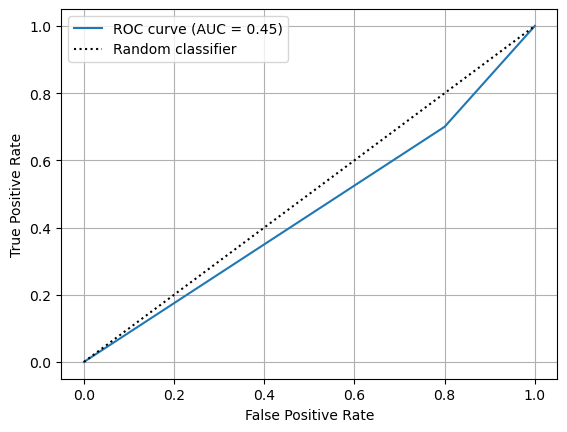

Test ROC AUC: 0.45


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder

def plot_roc_curve(y_true, y_pred):
    le = LabelEncoder()
    y_true_enc = le.fit_transform(y_true)
    y_pred_enc = le.transform(y_pred)
    fpr, tpr, thresholds = roc_curve(y_true_enc, y_pred_enc)
    auc = roc_auc_score(y_true_enc, y_pred_enc)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k:', label="Random classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()
    return auc

auc = plot_roc_curve(y_test, y_test_pred)
print(f"Test ROC AUC: {auc:.2f}")

auc = plot_roc_curve(y_test, y_test_pred_again)
print(f"Test ROC AUC with installment rate: {auc:.2f}")